# Polymer dynamics example

First run the example to train and save the trained model
The rest of the notebook will test the predictions of the mean, standard deviation and the unfolding time distribution.

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform' 
os.environ["HF_HOME"] = "~/nfs/hf_cache"
import jax 
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import equinox as eqx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

from omegaconf import OmegaConf
from utils_reduced_polymer import build_OnsagerNetHD2_scale
from examples.utils.sde import SDEIntegrator

/home/aiqing/nfs/hf_cache


Load test data

In [ ]:
import os 
os.environ["HF_HOME"] = "~/nfs/hf_cache"
from datasets import load_dataset
test_dataset = load_dataset("MLDS-NUS/Fs_Validation_Reduced")

@jax.jit
def compute_unfolding_time(traj):
    unfolded_extension = traj[:, -1, 0]
    threshold = 0.95 * unfolded_extension
    first_index = jnp.argmin(traj[:, :, 0] <= threshold[:, None], axis=1)
    return first_index


Plotting F23_10_T1 in outputs/main12_HD2


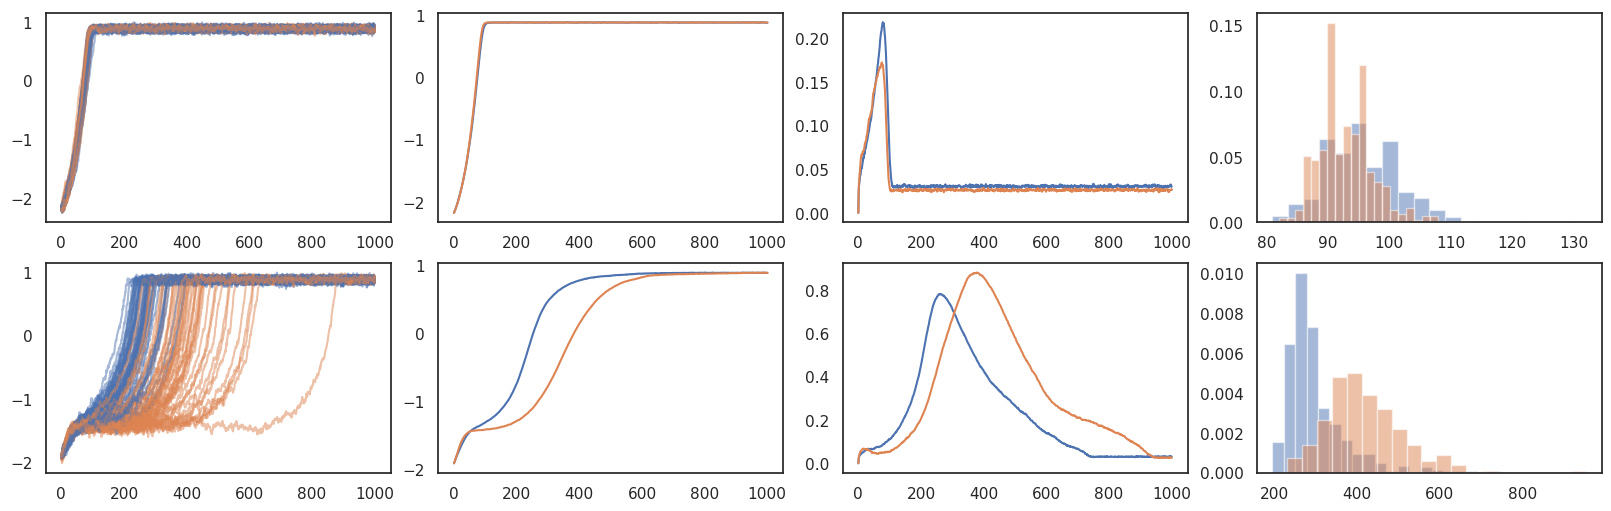

Plotting F16_20_T1 in outputs/main12_HD2


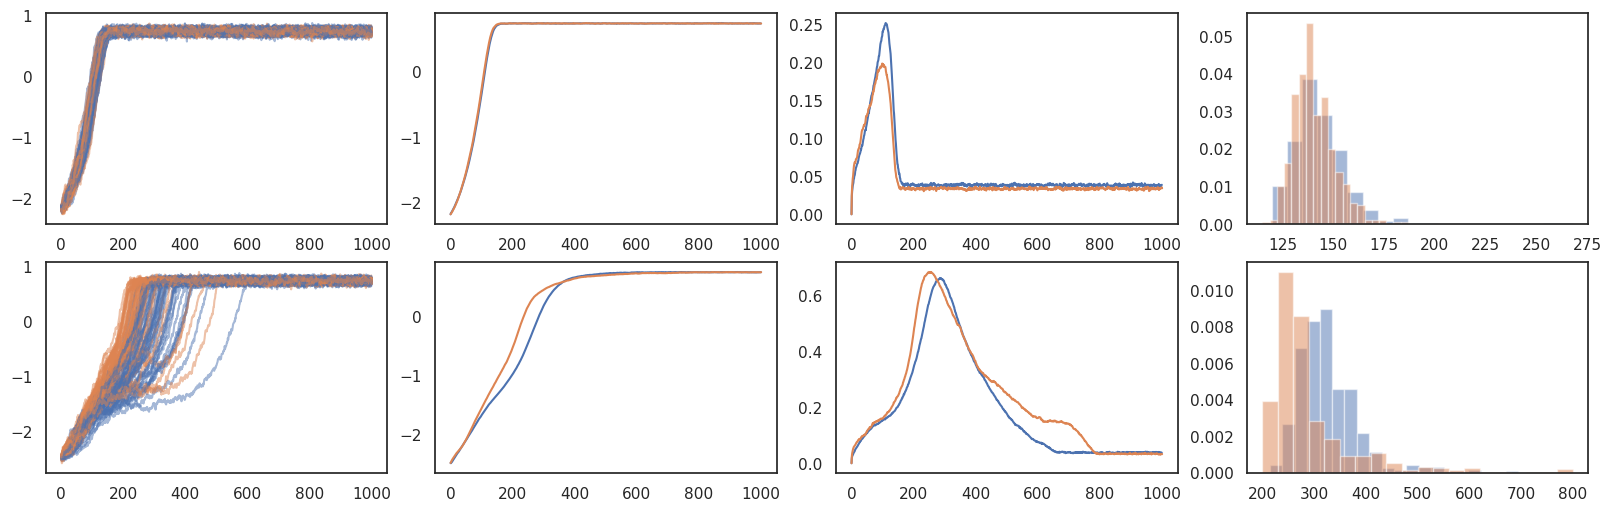

Plotting F11_60_T1 in outputs/main12_HD2


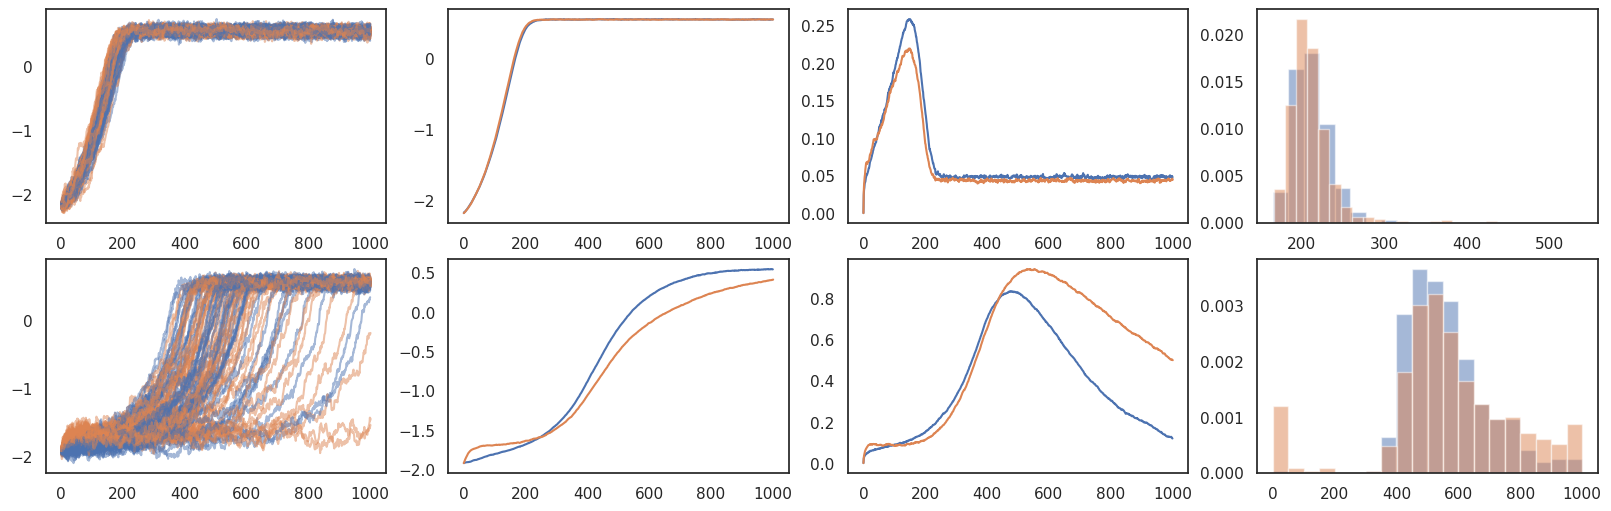

Plotting F4_63_T1 in outputs/main12_HD2


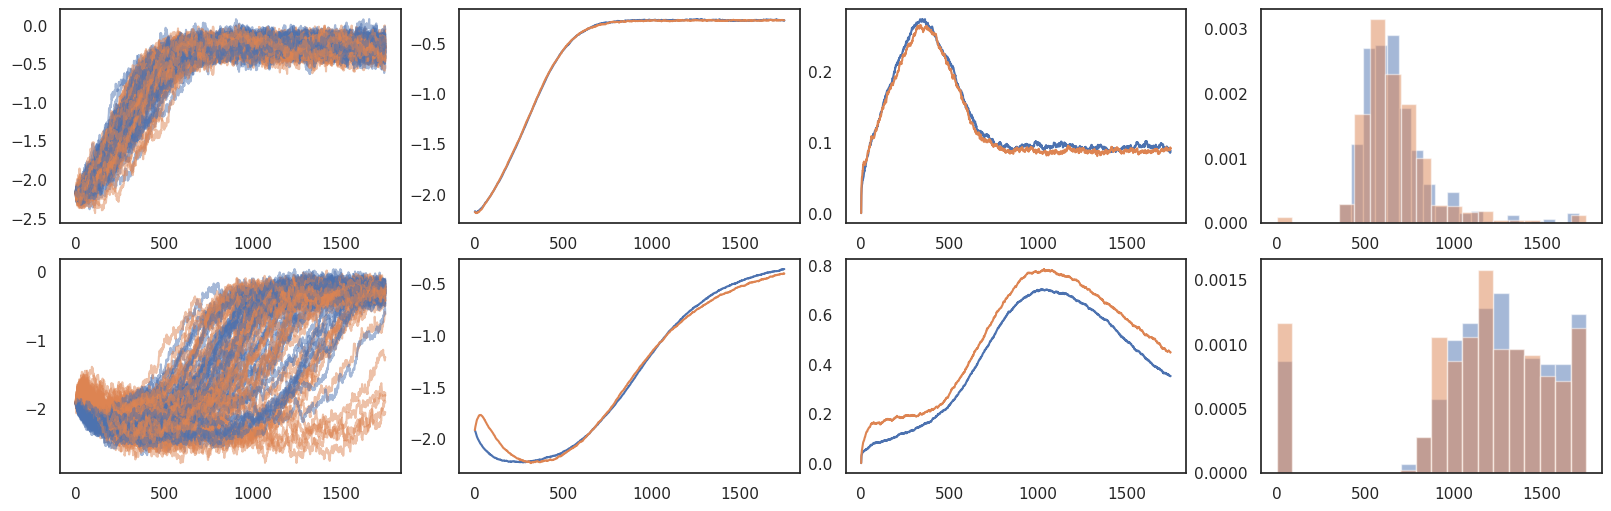

Plotting F3_93_T1 in outputs/main12_HD2


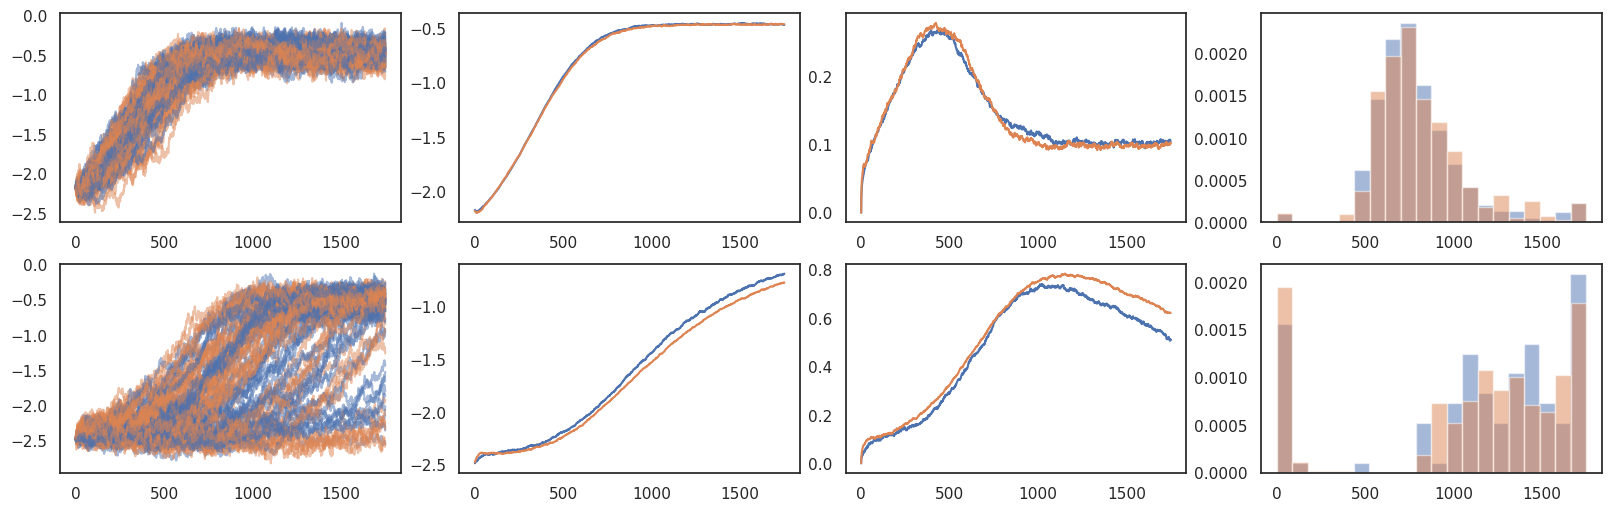

Plotting F2_78_T1 in outputs/main12_HD2


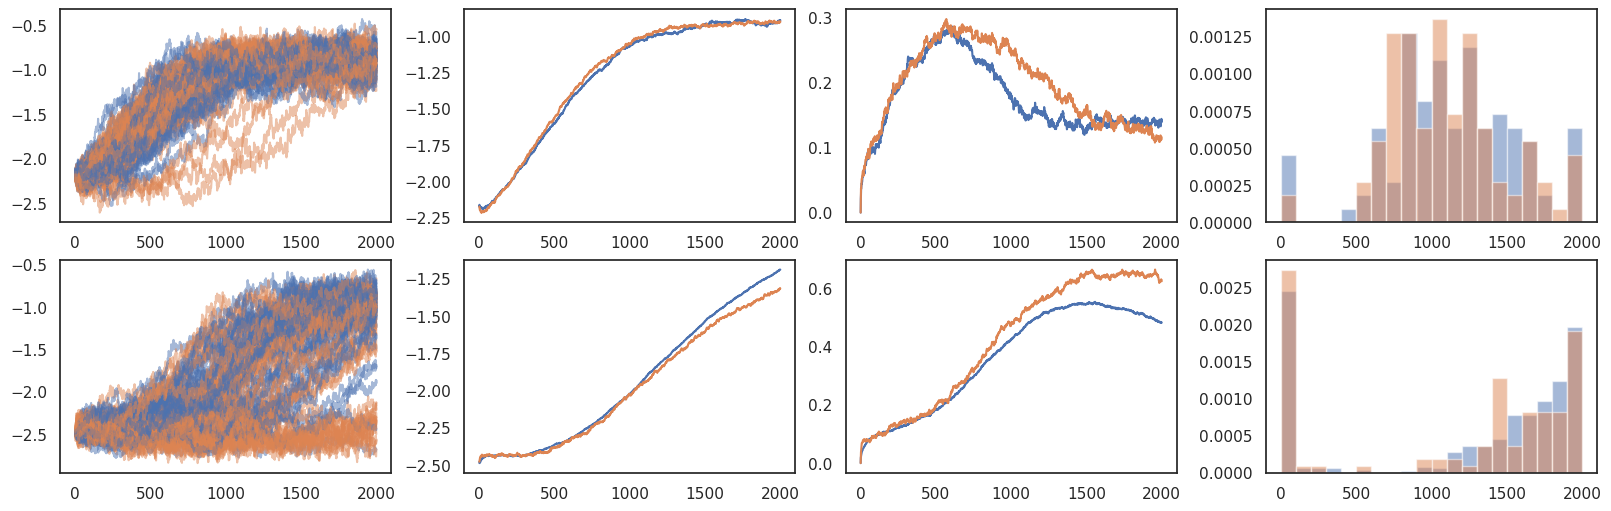

Plotting F2_31_T1 in outputs/main12_HD2


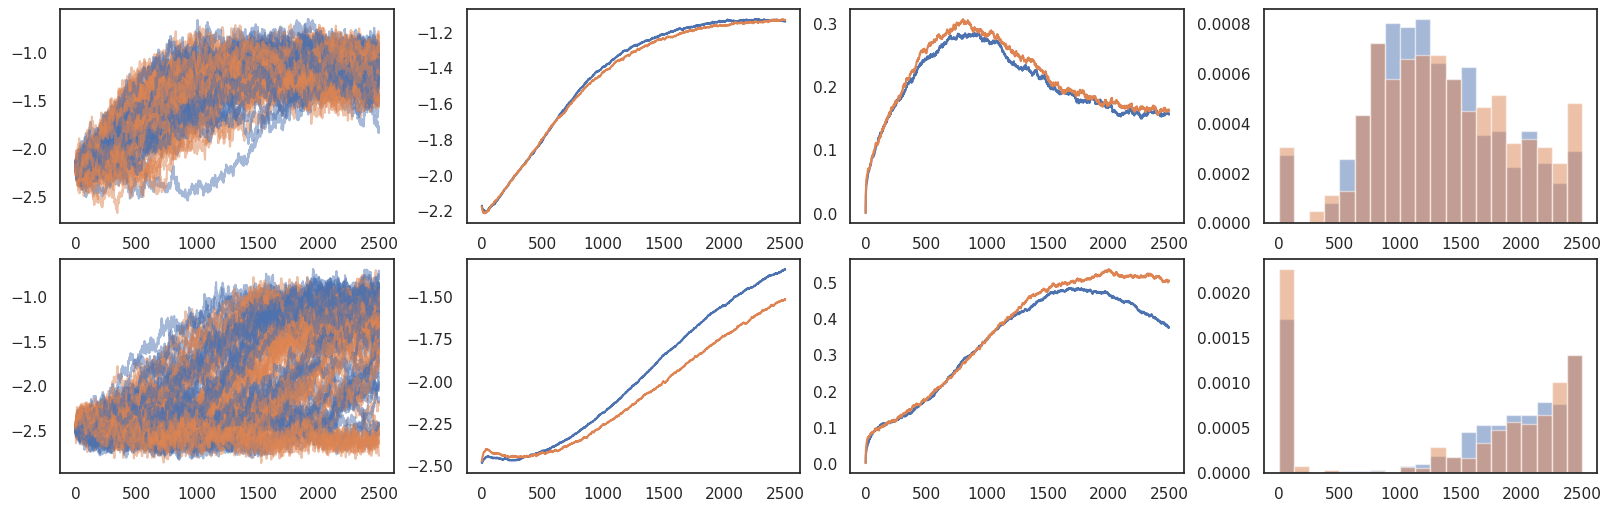

Plotting F1_62_T1 in outputs/main12_HD2


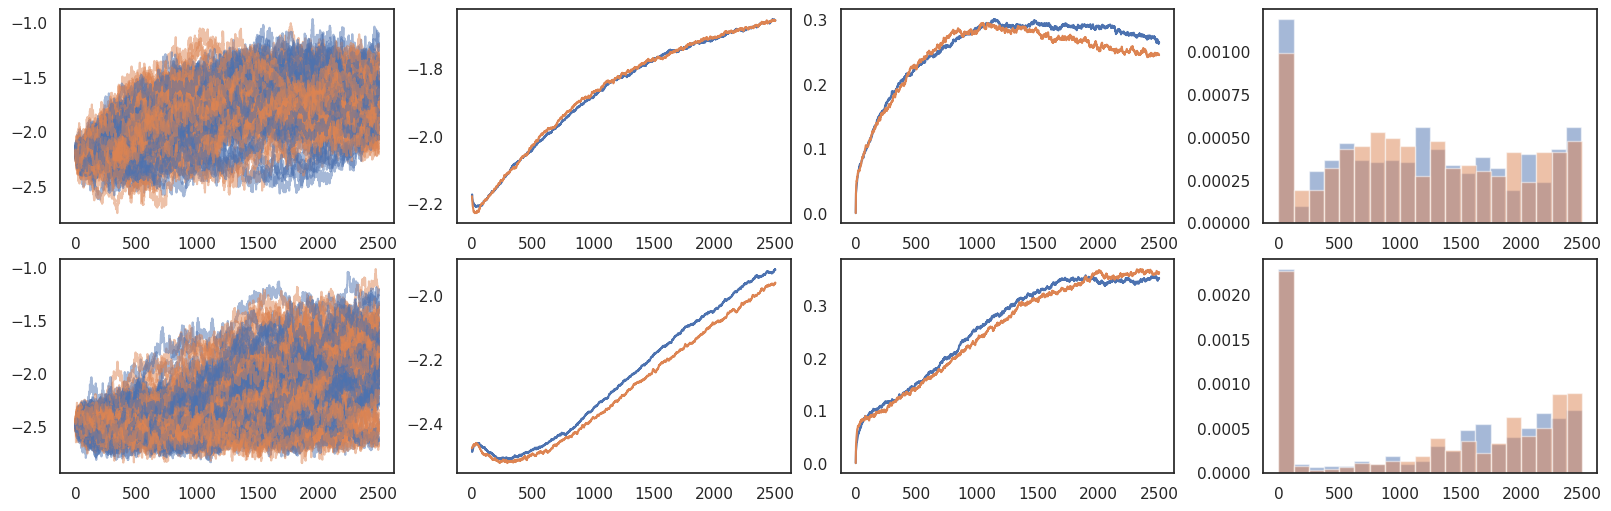

In [ ]:
def plot_testing_traj(net, test_dataset, data_set_key, config):

    key = jr.PRNGKey(config.model.seed + 1234) 

    test_data = test_dataset.with_format("numpy")
    test_split = data_set_key
    key
    return_results=False
    args_override=None
    test_data_fast = test_data[f"{test_split}_fast"]
    test_data_slow = test_data[f"{test_split}_slow"]
    test_x = [test_data_fast["x"], test_data_slow["x"]]
    test_args = [test_data_fast["args"][0,0], test_data_slow["args"][0,0]]

    # Generate predicted trajectories
    integrator = SDEIntegrator(model=net, state_dim=3)
    num_runs = test_data_fast.shape[0]
    keys = jr.split(key, 3)
    predicted_trajectories = []
    for key, traj, args in zip(keys, test_x, test_args):
        if args_override is not None:
            args = args_override
        init_conditions = jnp.repeat(traj[0, 0, :][None, :], num_runs, axis=0)
        bm_keys = jr.split(key, num_runs)
        sol = integrator.parallel_solve(
            key=bm_keys,
            initial_conditions=init_conditions,
            t0=0.0,
            t1=config.dt * test_x[0].shape[1],
            dt=config.dt/2,
            args=args,
        )
        predicted_trajectories.append(sol.ys[:,::2])

    # Compute statistics
    fig, ax = plt.subplots(2, 4, figsize=(16, 5), layout="constrained")
    true_unfolding_time_list = []
    pred_unfolding_time_list = []
    for a, true, pred in zip(ax, test_x, predicted_trajectories):
        true_mean = jnp.mean(true, axis=0)
        pred_mean = jnp.mean(pred, axis=0)

        for i in range(50):
            a[0].plot(true[i, :, 0], label="True", color='C0', alpha=0.5)
            a[0].plot(pred[i, :, 0], label="Pred", color='C1', alpha=0.5)
        # a[0].set_title("Trajectories")

        a[1].plot(true_mean[:, 0], label="True")
        a[1].plot(pred_mean[:, 0], label="Pred")
        # a[1].set_title("Mean")

        true_std = jnp.std(true, axis=0)
        pred_std = jnp.std(pred, axis=0)

        a[2].plot(true_std[:, 0])
        a[2].plot(pred_std[:, 0])
        # a[2].set_title("Standard deviation")

        true_unfolding_time = compute_unfolding_time(true)
        pred_unfolding_time = compute_unfolding_time(pred)

        a[3].hist(true_unfolding_time, label="True", alpha=0.5, density=True, bins=20)
        a[3].hist(pred_unfolding_time, label="Pred", alpha=0.5, density=True, bins=20)
        # a[3].set_title("Unfolding time")
 
    print(f"Plotting {data_set_key} in {path}")
    plt.show()


data_set_key_list=["F23_10_T1", "F16_20_T1", "F11_60_T1", 
                   "F4_63_T1", "F3_93_T1", "F2_78_T1", "F2_31_T1", "F1_62_T1"
                  ] 
for data_set_key in data_set_key_list:
    for seed in [12]:
        path =  f"outputs/main{seed}_HD2"
        config = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
        model_template = build_OnsagerNetHD2_scale(config)
        net = eqx.tree_deserialise_leaves(os.path.join(path,data_set_key + '/model.eqx'), model_template) 
        plot_testing_traj(net, test_dataset, data_set_key, config)

Plotting F23_10_T1 in outputs/main12_HD2


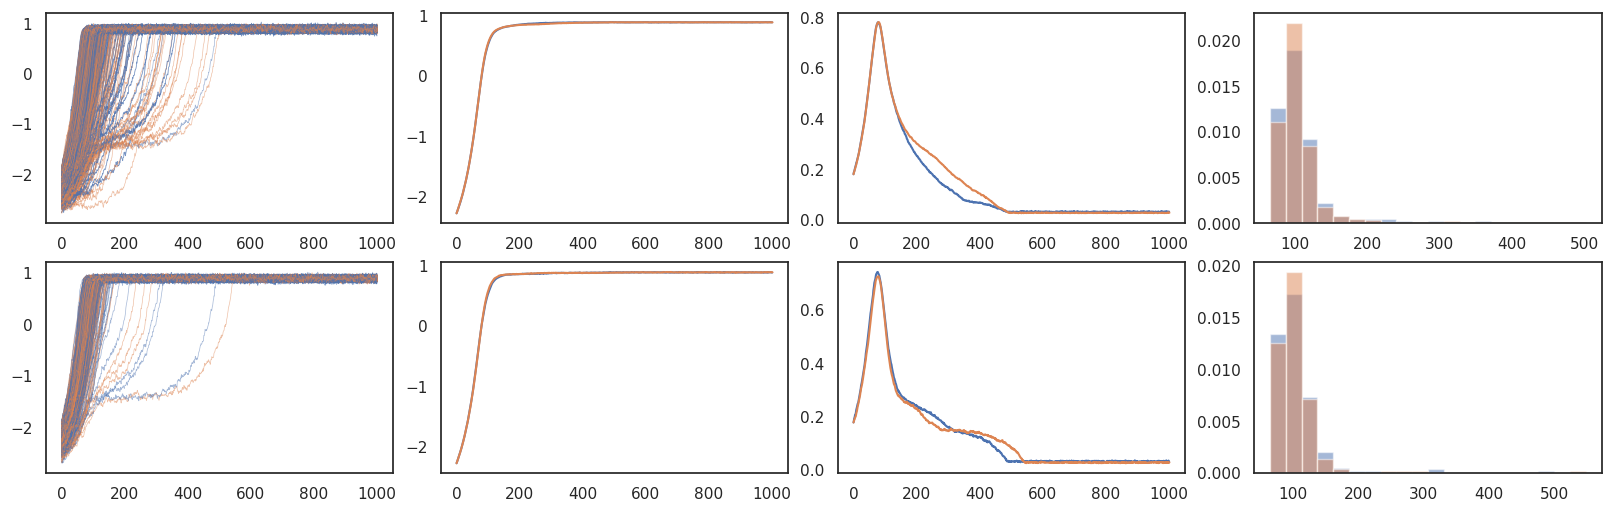

Plotting F16_20_T1 in outputs/main12_HD2


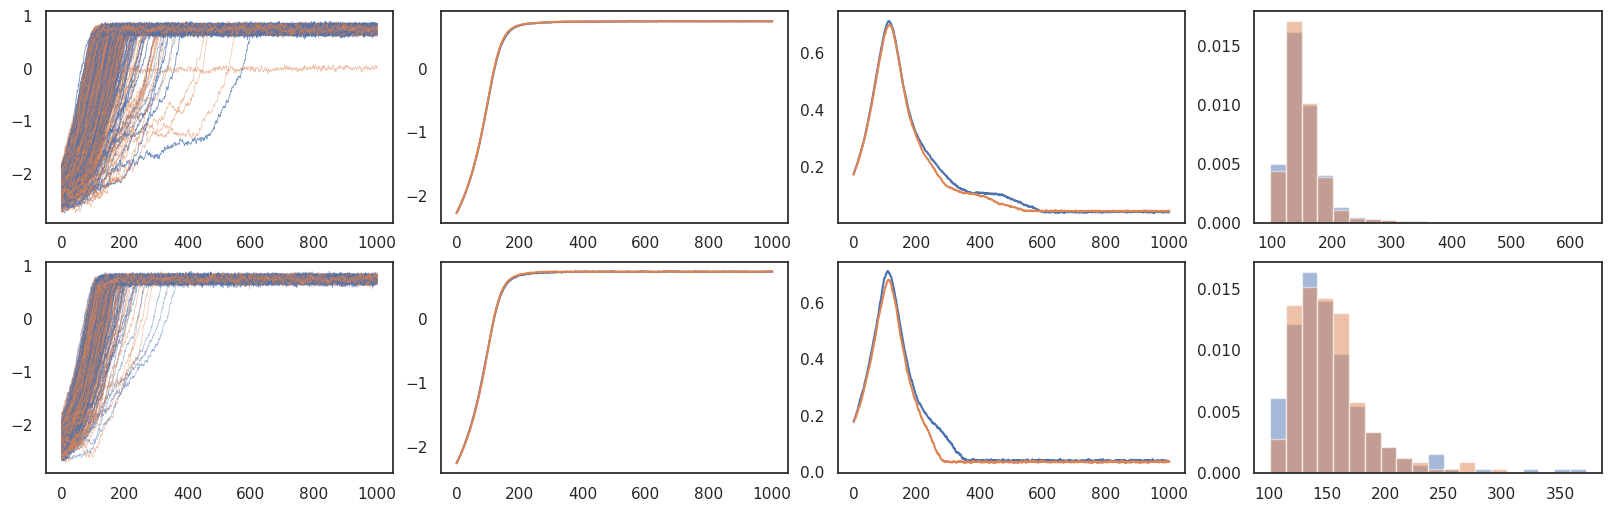

Plotting F11_60_T1 in outputs/main12_HD2


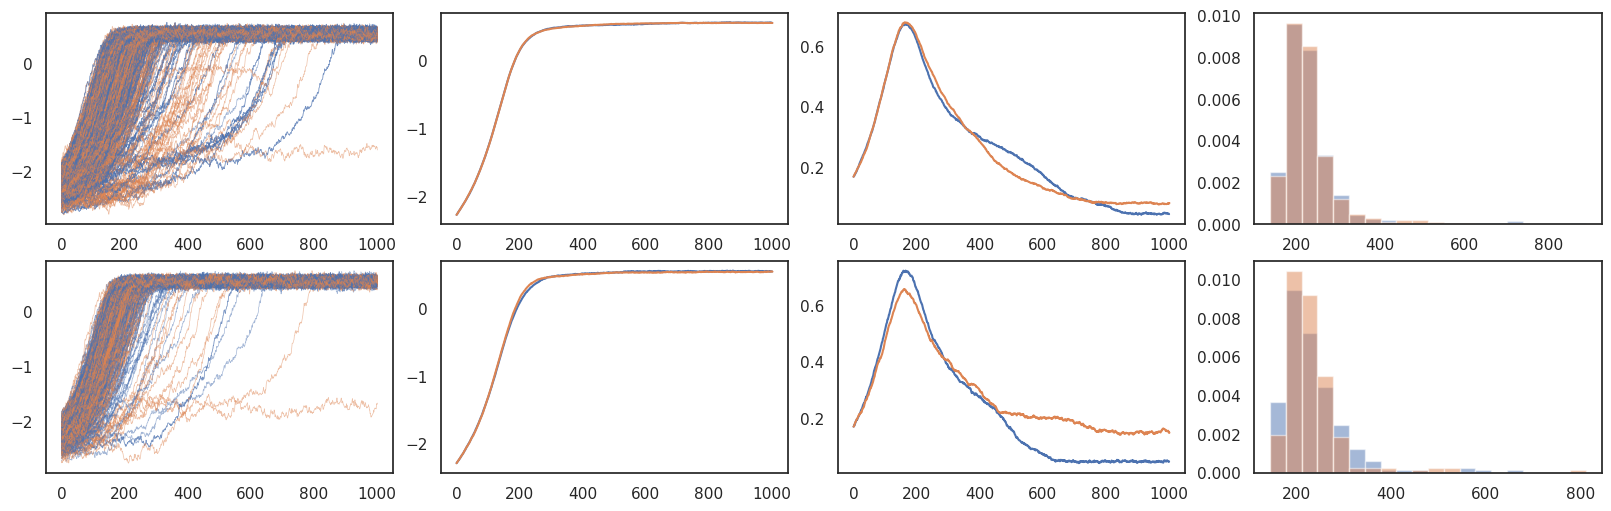

Plotting F4_63_T1 in outputs/main12_HD2


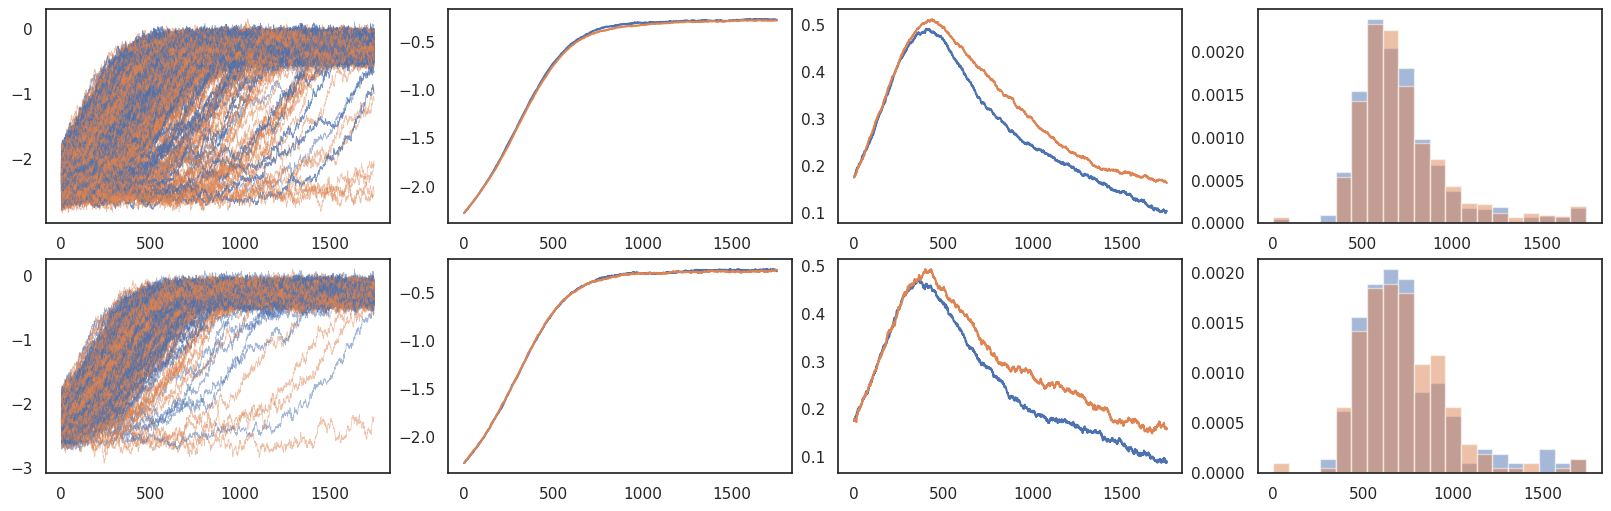

Plotting F3_93_T1 in outputs/main12_HD2


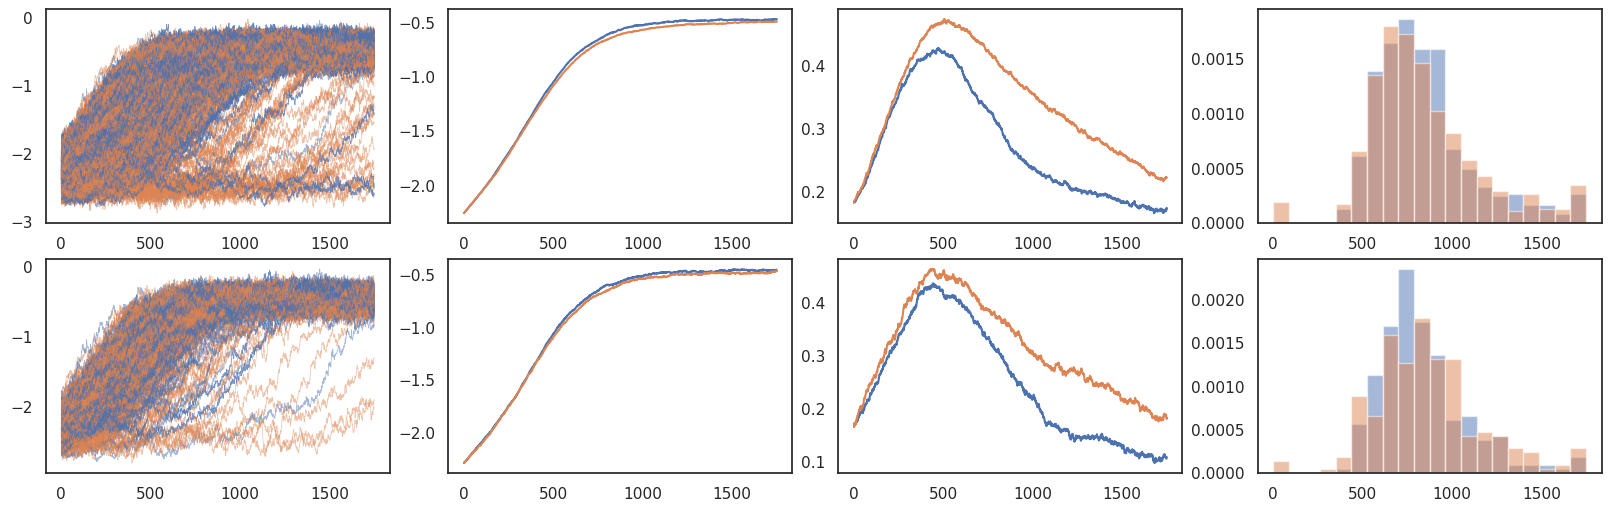

Plotting F2_78_T1 in outputs/main12_HD2


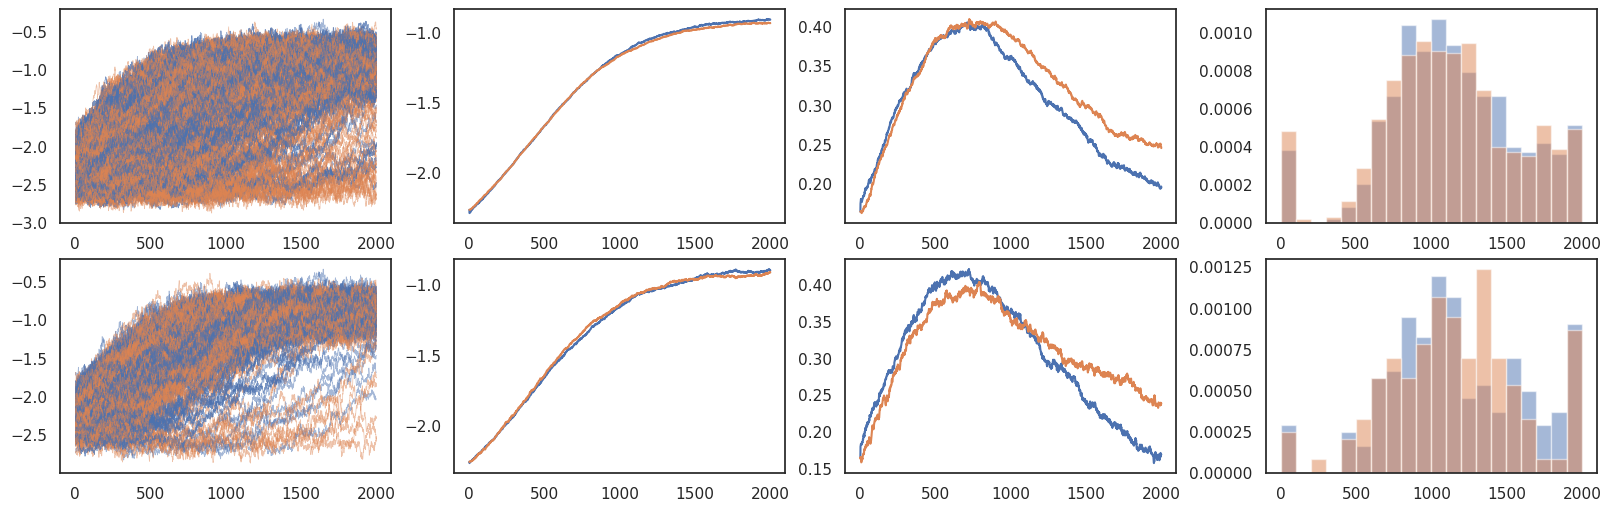

Plotting F2_31_T1 in outputs/main12_HD2


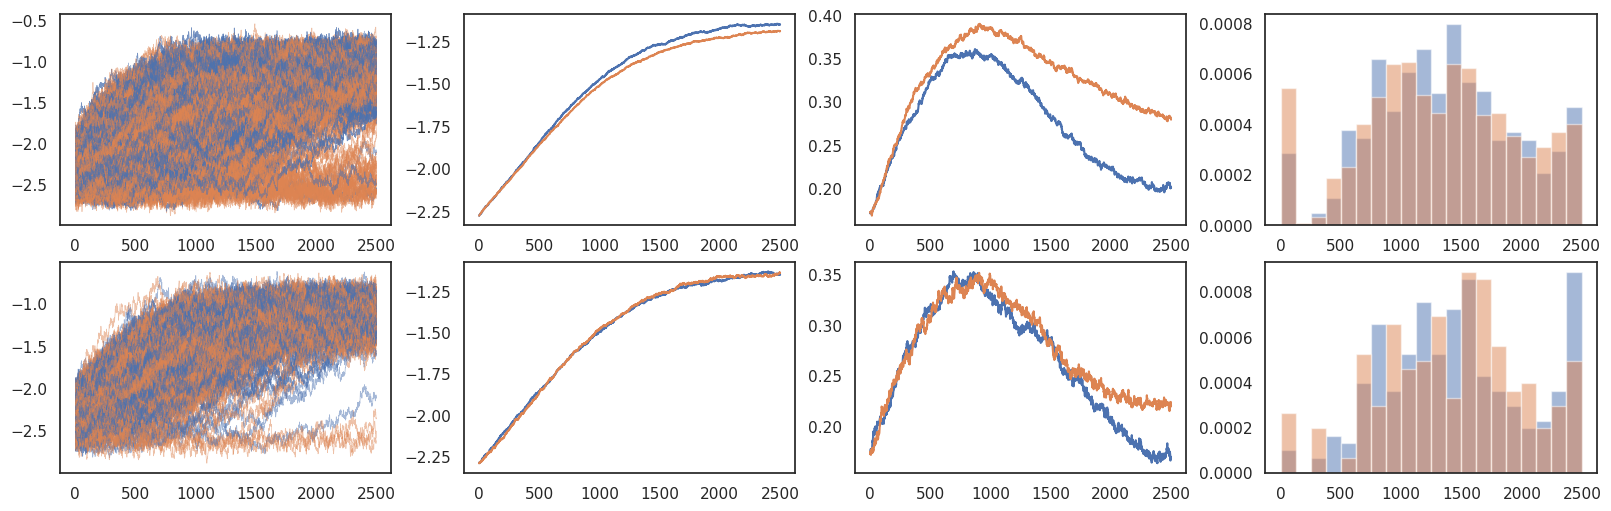

Plotting F1_62_T1 in outputs/main12_HD2


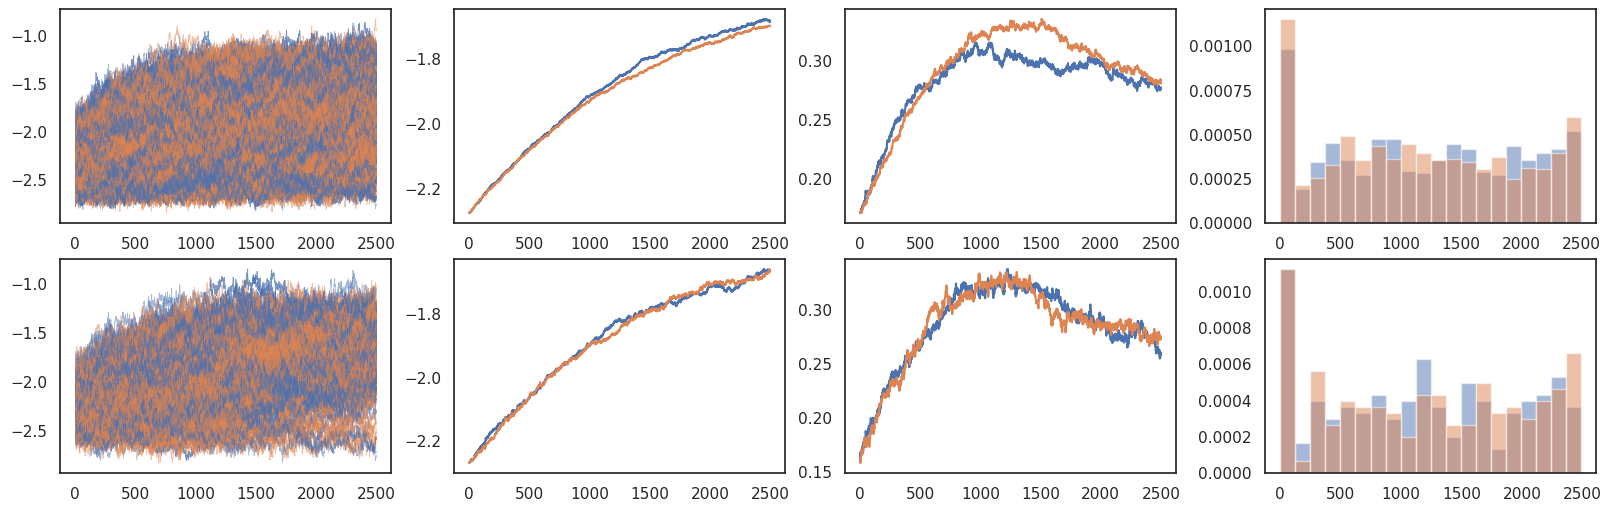

In [ ]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
load_path = os.path.join('OriginalData', 'dataset.pkl')

with open(load_path, 'rb') as f:
    loaded_dataset = pickle.load(f)

dataset_name = "F4_63_T1"
dataset = loaded_dataset[dataset_name]
x_train, x_test= train_test_split(dataset['x'], test_size=0.2, random_state=42)

def plot_training_traj(net, loaded_dataset, data_set_key, config):

    key = jr.PRNGKey(config.model.seed + 1234)
    dataset = loaded_dataset[data_set_key]
    x_train, x_validation= train_test_split(dataset['x'], test_size=0.2, random_state=42)
    x_train, x_validation= jnp.array(x_train), jnp.array(x_validation)
    args_override=None 
 
    test_x = [x_train, x_validation]
    test_args = [dataset["args"][0][0], dataset["args"][0][0]]

    # Generate predicted trajectories
    integrator = SDEIntegrator(model=net, state_dim=3) 
    keys = jr.split(key, 3)
    predicted_trajectories = []
    for key, traj, args in zip(keys, test_x, test_args):
        if args_override is not None:
            args = args_override
        # init_conditions = jnp.repeat(traj[0, 0, :][None, :], num_runs, axis=0)
        init_conditions = jnp.array(traj[:, 0, :])

        bm_keys = jr.split(key, len(init_conditions))
        sol = integrator.parallel_solve(
            key=bm_keys,
            initial_conditions=init_conditions,
            t0=0.0,
            t1=config.dt * test_x[0].shape[1],
            dt=config.dt/2,
            args=args,
        )
        predicted_trajectories.append(sol.ys[:,::2])

    # Compute statistics
    fig, ax = plt.subplots(2, 4, figsize=(16, 5), layout="constrained")
    for a, true, pred in zip(ax, test_x, predicted_trajectories):
        true_mean = jnp.mean(true, axis=0)
        pred_mean = jnp.mean(pred, axis=0)

        for i in range(len(true)):
            a[0].plot(true[i, :, 0], label="True", color='C0', alpha=0.5, linewidth=0.5)
            a[0].plot(pred[i, :, 0], label="Pred", color='C1', alpha=0.5, linewidth=0.5)
        # a[0].set_title("Trajectories")

        a[1].plot(true_mean[:, 0], label="True")
        a[1].plot(pred_mean[:, 0], label="Pred")
        # a[1].set_title("Mean")

        true_std = jnp.std(true, axis=0)
        pred_std = jnp.std(pred, axis=0)

        a[2].plot(true_std[:, 0])
        a[2].plot(pred_std[:, 0])
        # a[2].set_title("Standard deviation")

        true_unfolding_time = compute_unfolding_time(true)
        pred_unfolding_time = compute_unfolding_time(pred)

        xmin = min(true_unfolding_time.min(), pred_unfolding_time.min())
        xmax = max(true_unfolding_time.max(), pred_unfolding_time.max())

        bins = np.linspace(xmin, xmax, 21)

        a[3].hist(true_unfolding_time, label="True", alpha=0.5, density=True, bins=bins)
        a[3].hist(pred_unfolding_time, label="Pred", alpha=0.5, density=True, bins=bins)
 
    print(f"Plotting {data_set_key} in {path}")
    plt.show()


data_set_key_list=["F23_10_T1", "F16_20_T1", "F11_60_T1", 
                   "F4_63_T1", "F3_93_T1", "F2_78_T1", "F2_31_T1", "F1_62_T1"
                  ] 
for data_set_key in data_set_key_list:
    for seed in [12]:
        path =  f"outputs/main{seed}_HD2"
        config = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
        model_template = build_OnsagerNetHD2_scale(config)
        net = eqx.tree_deserialise_leaves(os.path.join(path,data_set_key + '/model.eqx'), model_template)
        plot_training_traj(net, loaded_dataset, data_set_key, config)